# Module 3 Project - Whisky Sommelier
# EDA and Feature Engineering
By: **Maura Cerow**, **Rajeev Panwar** and **Bryan Santos**

This project aims to build the first module of a comprehensive whisky recommendation engine, an **automated whisky sommelier**. We would like this to act as a go-to "middle-man" between distributors, bars and consumers.

This notebook in particular handles the EDA and resulting feature engineering. The source is https://www.distiller.com.

## Dataset

After data cleaning, we have retained a total of 2,622 observations in our dataset. The following are our target and feature variables. We still plan to add some new predictors based on the resulting EDA and feature interactions. 

**Target**  
- Whisky's country of origin: 
    - Scotland
    - Japan
    - USA
    - Canada
    - Ireland

**Features**
- Type (whether it is Single Malt, Blended, Rye, etc.)
- Price (ranging from 1 to 5 with 5 being the most expensive)
- Expert Score (critic score)
- User Rating (distiller.com user reviews)
- ABV (Alcohol By Volume)
- Description
- Style (ingredients)
- Maturing/Cask (whether matured in Oak, Sherry, etc.)
- Flavor Profiles (each having intensity scores ranging from 0 to 100):
    - *Smoky*
    - *Peaty*
    - *Spicy*
    - *Herbal*
    - *Oily*
    - *Full-Bodied*
    - *Rich*
    - *Sweet*
    - *Briny*
    - *Salty*
    - *Vanilla*
    - *Tart*
    - *Fruity*
    - *Floral*

## Package Imports and Data Load

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno

sns.set()
%matplotlib inline

### Suppress notebook warnings ###
import warnings
warnings.filterwarnings('ignore')

### Pandas settings to avoid exponential form and display all columns ###
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

In [85]:
df = pd.read_csv("whisky_df_clean.csv", sep=',')

In [86]:
df.head(5)

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
0,Hibiki 21 Year,Blended,5,99,4.520,Hibiki is the blended whisky brand produced by...,43.000,Comprised of both single malt(s) and single gr...,"ex-bourbon American oak, ex-sherry European oa...","""Tasting this whisky was one of those moments ...",30,30,50,30,20,80,80,85,0,15,20,25,85,50,4
1,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,ex-sherry,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0
2,George T. Stagg Bourbon (Fall 2019),Bourbon,4,98,4.590,George T. Stagg Bourbon (Fall 2019) is an uncu...,58.450,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak","""Lots of oak shows up on the nose along with c...",40,40,65,50,20,60,60,45,0,0,60,60,45,0,1
3,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,"ex-bourbon, ex-sherry, new Mizunara oak","""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0
4,The Macallan M,Single Malt,5,98,4.190,A 6-litre Lalique decanter of this single malt...,47.700,Distilled in pot stills from 100% malted barle...,sherry oak casks,"""The aroma is that pleasing bouquet that comes...",50,50,60,0,15,90,100,50,0,0,20,20,80,10,0


## EDA

### Target variable - country of origin

In [87]:
df['country'].value_counts()

1    1192
0    1032
2     175
3     152
4     111
Name: country, dtype: int64

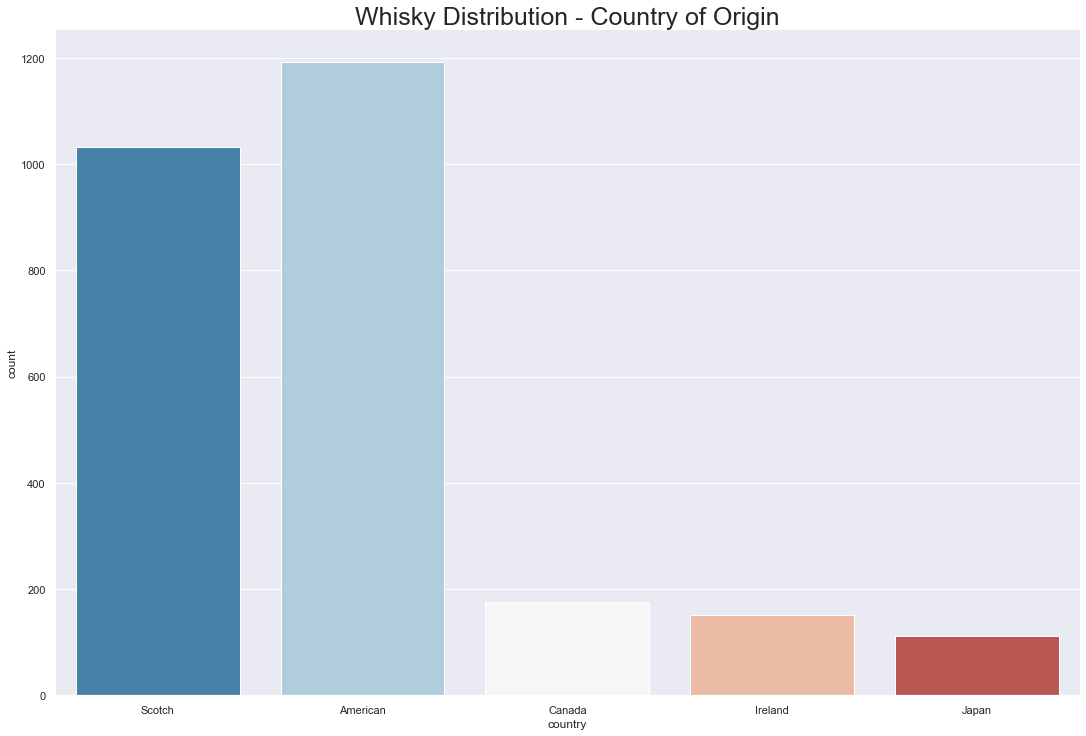

In [88]:
ax = sns.catplot(x="country", kind="count", palette="RdBu_r", data=df, height=10, aspect=15/10)
ax.set(xticklabels=['Scotch', 'American', 'Canada', 'Ireland', 'Japan'])
sns.set(font_scale=2)

plt.title('Whisky Distribution - Country of Origin', {'fontsize': 25})
plt.show()

Based on the value counts and on the graph above, there is indeed class imbalance. Scotch and American whiskies comprise majority of the observations in the dataset. To avoid class imbalance leading to inaccurate models and predictions, we will handle the imbalance later on using various techniques. Then we will compare the scores against models without imbalance handling to see if they are effective.

### Handling missing numeric values

In [89]:
df.describe()

,price,expert_score,user_rating,abv,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
count,2662.000,2662.000,2587.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000
mean,3.058,86.391,3.740,46.892,23.643,23.643,46.235,26.002,29.515,54.434,54.526,55.985,9.080,10.597,43.807,24.030,44.886,22.643,0.917
std,1.158,5.895,0.569,6.345,21.067,21.067,20.849,19.499,20.115,18.848,19.436,18.721,15.579,15.632,20.689,18.657,23.127,20.548,1.025
min,1.000,40.000,0.000,30.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.000,83.000,3.420,43.000,10.000,10.000,30.000,10.000,15.000,40.000,40.000,40.000,0.000,0.000,30.000,10.000,25.000,10.000,0.000
50%,3.000,87.000,3.760,46.000,20.000,20.000,50.000,20.000,30.000,55.000,60.000,60.000,0.000,5.000,40.000,20.000,40.000,20.000,1.000
75%,4.000,90.000,4.140,50.000,35.000,35.000,60.000,40.000,40.000,70.000,70.000,70.000,10.000,17.000,60.000,40.000,65.000,30.000,1.000
max,5.000,99.000,5.000,80.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,90.000,100.000,90.000,100.000,90.000,4.000


It seems only user rating has missing values based on our observation above. But there might be more to it than what meets the eye. Some user rating has a value of 0.00 which means it should have been null. 

The first step to address this is to convert all 0.00 values into nan. 

In [90]:
df.loc[df["user_rating"] == 0.000, "user_rating"] = np.NAN

A better way to analyze missing values is by drawing a nullity matrix.

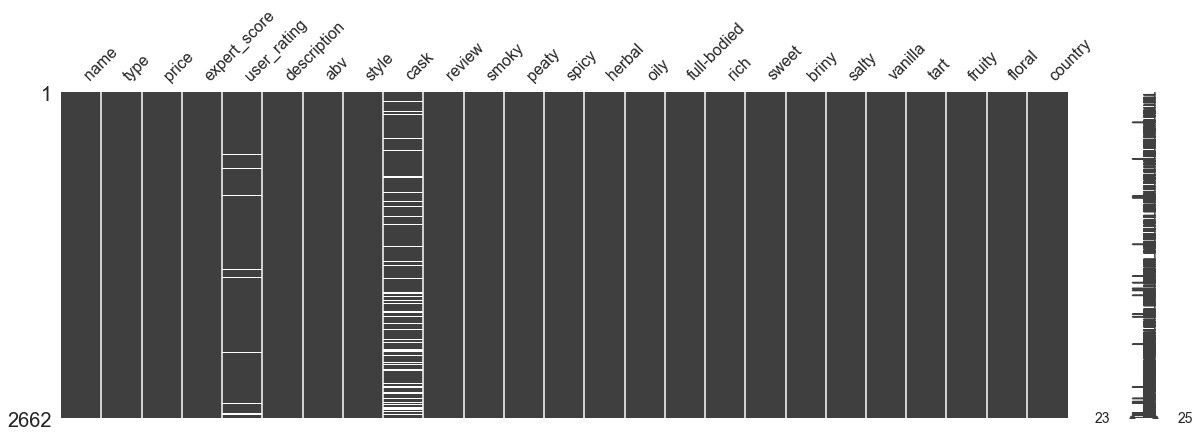

In [91]:
mno.matrix(df, figsize = (20, 6))
plt.show()

We also see that cask has missing values but since it is not yet numeric, we will deal with this later. Let us deal with user rating first using *imputation based on another semi-related variable*.

**Expert scores** and **user ratings** are both subjective quantitative review assessment of each whisky. The plan is to compute for the missing user ratings based on the expert score because we have complete expert score values. We will divide the expert score mean over user rating mean to get the weight of expert score in terms of user rating. To get the missing user rating, we will divide its expert score over the weight.



In [92]:
### Compure for the standard weight of expert scores against user ratings ###
weight = df['expert_score'].mean() / df['user_rating'].mean()

In [93]:
### Impute weighted user score if value is missing ###
df['user_rating'] = df.apply(
    lambda row: row['expert_score'] / weight if np.isnan(row['user_rating']) else row['user_rating'],
    axis=1
)

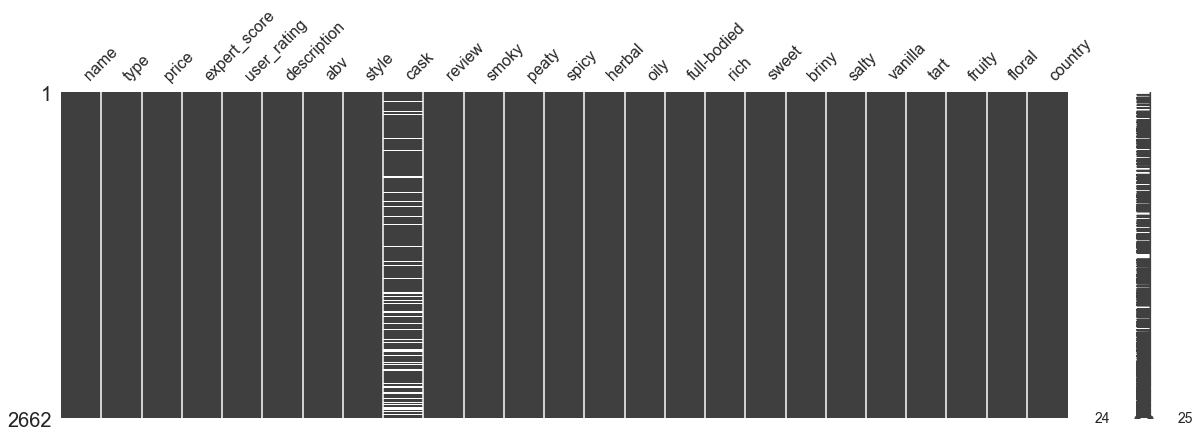

In [94]:
### Validate result ###
mno.matrix(df, figsize = (20, 6))
plt.show()

### Flavor profiles

In [95]:
df.columns

Index(['name', 'type', 'price', 'expert_score', 'user_rating', 'description',
       'abv', 'style', 'cask', 'review', 'smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral', 'country'],
      dtype='object')

In [96]:
### Create a df of only the flavor profiles ###
flavor_df = df[['smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral']]

In [97]:
### Check correlation ###
flavor_df.corr()

,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
smoky,1.000,1.000,0.208,0.192,0.206,0.192,0.171,-0.069,0.441,0.407,0.072,0.126,0.063,0.044
peaty,1.000,1.000,0.208,0.192,0.206,0.192,0.171,-0.069,0.441,0.407,0.072,0.126,0.063,0.044
spicy,0.208,0.208,1.000,0.426,0.276,0.277,0.250,0.114,0.047,0.116,0.354,0.280,0.203,0.202
herbal,0.192,0.192,0.426,1.000,0.335,0.085,0.076,0.035,0.174,0.209,0.244,0.357,0.179,0.380
oily,0.206,0.206,0.276,0.335,1.000,0.305,0.279,0.113,0.306,0.318,0.289,0.260,0.203,0.269
full-bodied,0.192,0.192,0.277,0.085,0.305,1.000,0.844,0.436,0.123,0.183,0.303,0.066,0.233,0.084
rich,0.171,0.171,0.250,0.076,0.279,0.844,1.000,0.475,0.097,0.152,0.325,0.072,0.279,0.129
sweet,-0.069,-0.069,0.114,0.035,0.113,0.436,0.475,1.000,-0.051,0.049,0.477,0.119,0.446,0.257
briny,0.441,0.441,0.047,0.174,0.306,0.123,0.097,-0.051,1.000,0.781,0.013,0.139,0.107,0.153
salty,0.407,0.407,0.116,0.209,0.318,0.183,0.152,0.049,0.781,1.000,0.115,0.176,0.208,0.215


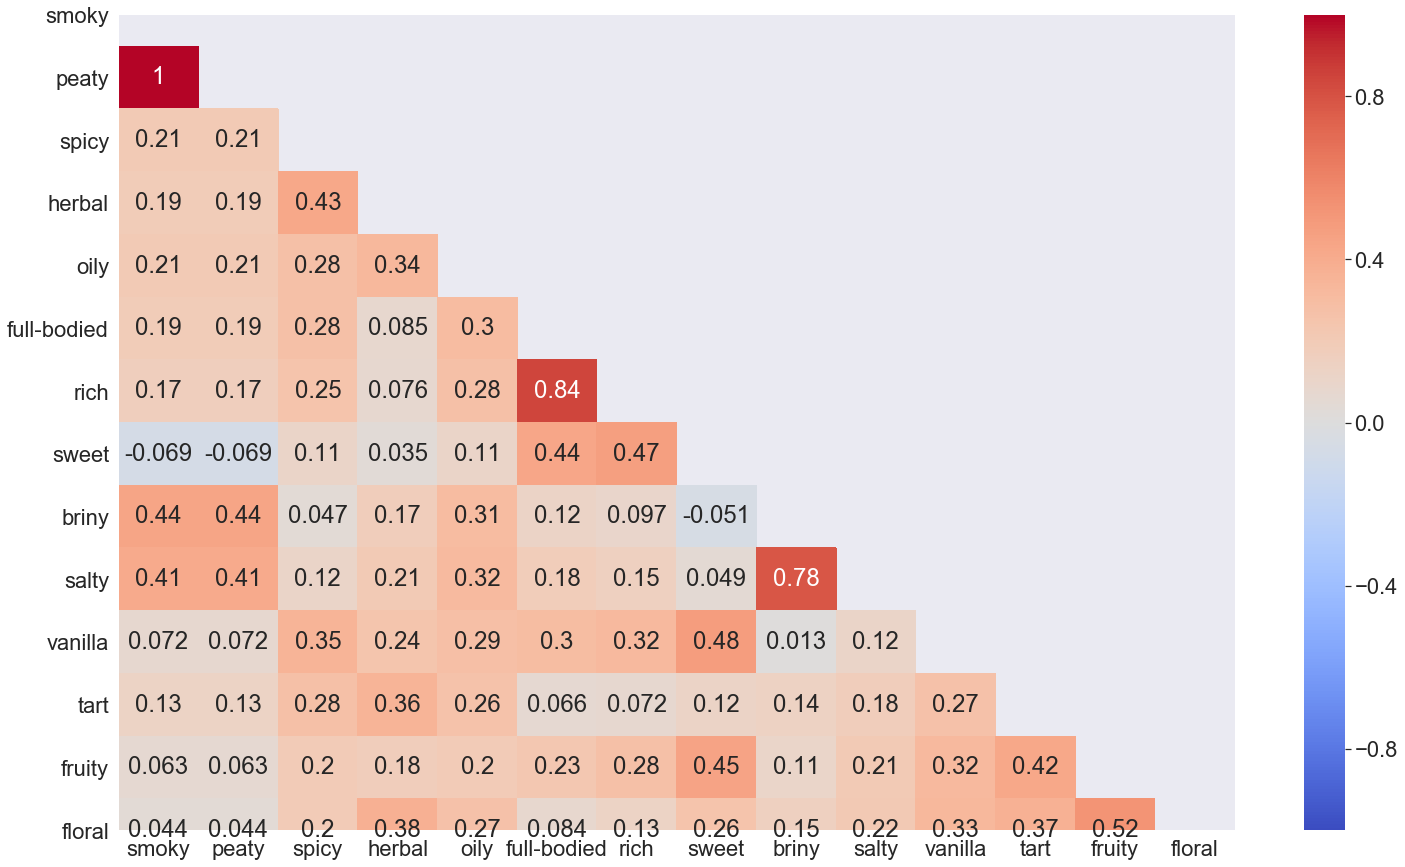

In [98]:
### Plot correlation between flavor profiles ###

f, ax = plt.subplots(figsize=(25, 15))
matrix = np.triu(flavor_df.corr())
sns.heatmap(flavor_df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)
plt.show()

# Handling Missing Cask Values

We have null values in our Cask column. Different casks offer different flavors and we believe the cask is indicative of type of whiksy we're trying to predict. 

In [99]:
df.head()

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
0,Hibiki 21 Year,Blended,5,99,4.520,Hibiki is the blended whisky brand produced by...,43.000,Comprised of both single malt(s) and single gr...,"ex-bourbon American oak, ex-sherry European oa...","""Tasting this whisky was one of those moments ...",30,30,50,30,20,80,80,85,0,15,20,25,85,50,4
1,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,ex-sherry,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0
2,George T. Stagg Bourbon (Fall 2019),Bourbon,4,98,4.590,George T. Stagg Bourbon (Fall 2019) is an uncu...,58.450,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak","""Lots of oak shows up on the nose along with c...",40,40,65,50,20,60,60,45,0,0,60,60,45,0,1
3,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,"ex-bourbon, ex-sherry, new Mizunara oak","""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0
4,The Macallan M,Single Malt,5,98,4.190,A 6-litre Lalique decanter of this single malt...,47.700,Distilled in pot stills from 100% malted barle...,sherry oak casks,"""The aroma is that pleasing bouquet that comes...",50,50,60,0,15,90,100,50,0,0,20,20,80,10,0


In [100]:
### A lot of the style observations include the cask. The plan is to parse through the styles to pull out the cask
### details for each null value.

df['style'].iloc[0]

'Comprised of both single malt(s) and single grain(s) often from many different distilleries; if Scotch or Irish must be aged for at least three years in oak barrels; Irish may include single pot still whiskey in the blend.'

In [101]:
### identifying the number of null values we have.

df['cask'].isnull().sum()

449

In [102]:
df.columns

Index(['name', 'type', 'price', 'expert_score', 'user_rating', 'description',
       'abv', 'style', 'cask', 'review', 'smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral', 'country'],
      dtype='object')

In [103]:
### setting a new dataframe for our null values. this is just for reference to see just the observations we want to
### update

cask_nas = df[df['cask'].isnull() == True]
cask_nas.head()

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
21,Hibiki 30 Year,Blended,5,97,4.840,This blended whisky is comprised of single mal...,43.000,Comprised of both single malt(s) and single gr...,NaN,"""Orange marmalade, rich dark chocolate, and ap...",20,20,75,30,20,65,70,85,20,15,30,10,85,25,4
44,Hibiki 30 Year,Blended,5,97,4.840,This blended whisky is comprised of single mal...,43.000,Comprised of both single malt(s) and single gr...,NaN,"""Orange marmalade, rich dark chocolate, and ap...",20,20,75,30,20,65,70,85,20,15,30,10,85,25,4
46,Glenmorangie 1970's Collection '77,Single Malt,5,97,4.430,The 1977 entrant of the 1970s Collection was d...,43.000,Distilled in pot stills from 100% malted barle...,NaN,"""The nose begins dry, spicy and oaky, but a bu...",30,30,40,10,20,60,70,40,0,0,50,10,30,30,0
48,The Last Drop 48 Year Blended Scotch Whisky,Blended,5,97,4.580,This 48 Year blended whisky is the 4th release...,48.600,Comprised of both single malt(s) and single gr...,NaN,"""The nose bursts out at you from the glass, wi...",10,10,30,20,10,70,60,60,0,0,50,10,60,20,0
60,Mister Sam Blended Whiskey (2019 Release),Other Whiskey,5,96,4.850,Mister Sam Blended Whiskey is a limited releas...,66.900,A spirit distilled from a mash of grain(s) at ...,NaN,"""Drew Mayville juiced whisky from dynamite for...",60,60,55,20,35,65,65,45,0,0,45,20,55,25,2


In [104]:
cask_nas.shape

(449, 25)

In [105]:
cask_nas['style'].value_counts()

Distilled in pot stills from 100% malted barley, produced at one distillery, aged in barrels; if Scotch or Irish, must be aged for at least three years.                                                                                                                                                                            66
Comprised of both single malt(s) and single grain(s) often from many different distilleries; if Scotch or Irish must be aged for at least three years in oak barrels; Irish may include single pot still whiskey in the blend.                                                                                                      62
100% malted barley from a single distillery. Dried with peat.                                                                                                                                                                                                                                                                       54
DISTILLED IN CANADA

In [106]:
### to parse through the cask column, we've filled NA values with 'empty'.

df['cask'] = df['cask'].fillna('empty')

In [107]:
for i in df['cask']:
    if i is 'empty':
        df.loc[((df['style'] == "Comprised of both single malt(s) and single grain(s) often from many different distilleries; if Scotch or Irish must be aged for at least three years in oak barrels; Irish may include single pot still whiskey in the blend.")) , 'cask'] = 'oak'
        df.loc[((df['style'] == "Mash bill at least 51% rye; aged in new, charred oak barrels.\n")) , 'cask'] = 'oak'
        df.loc[((df['style'] == "Mash bill at least 80% corn, no requirement to age, but if aged, must be in either new un-charred oak barrels or used oak barrels.")), 'cask'] == "oak"
        df.loc[((df['style'] == 'Produced anywhere in USA; Mash bill of at least 51% corn; aged in new, charred oak containers.\n')), 'cask'] == 'oak'
        df.loc[((df['style'] == "Mash bill at least 51% wheat; aged in new, charred oak barrels\n")), 'cask'] = 'oak'
        df.loc[((df['style'] == "Mash bill at least 80% corn, no requirement to age, but if aged, must be in either new un-charred oak barrels or used oak barrels.")) , 'cask'] = 'oak'
        df.loc[((df['style'] == "Produced in Tennessee; mash grain at least 51% corn; aged in new, charred oak barrels; filtered through maple charcoal prior to aging.")) , 'cask'] = 'oak'
        df.loc[((df['style'] == "Made in the USA from 100% malted barley. Distilled at one distillery. Matured in oak casks no larger than 700L. Distilled to no higher than 160 proof (80% ABV). Bottled at 80 proof (40% ABV) or higher. (This is the proposed Standard of Identity by the American Single Malt Whiskey Commission.)\n\n")) , 'cask'] = 'oak'
        
    else:
        continue

In [108]:
for i in df['cask']:
    if i is 'empty':
        df.loc[((df['style'] == 'Produced anywhere in USA; Mash bill of at least 51% corn; aged in new, charred oak containers.\n')), 'cask'] = 'oak'
    
    else:
        continue

In [109]:
### after parsing through the style column, we were able to assign values to 106 observations
### we still have 343 observations that don't have a cask assigned to them

df[df['cask'] == 'empty'].shape

(343, 25)

Now that we've assigned cask values to observations we could, we learned we have 761 unique values in our cask column. Now, that's not entirely true. While there are a bunch of different casks, our observations have the same method, just written differently, ie - 

"new, charred American oak", "new charred American oak" and "new charred american oak"

We want to condense these into one single "oak" indicator. The way we go about that is standardizing all the observations - making everything lowercase, removing any punctuation and then capturing the key words in the original cask. We made a new column to do so to keep the two separate. Later, 'cask' will be dropped in favor of our 'cask_category' column.

In [112]:
# first and foremost, make everything lowercase
df['cask'] = df['cask'].map(lambda x: str(x).lower())
# removing any punctuation and conjunctions
df['cask'] = df['cask'].map(lambda x: str(x).replace('&', ""))
df['cask'] = df['cask'].map(lambda x: str(x).replace(' and ', " "))
df['cask'] = df['cask'].map(lambda x: str(x).replace('-', " "))
df['cask'] = df['cask'].map(lambda x: str(x).replace('/', " "))
df['cask'] = df['cask'].map(lambda x: str(x).replace(',', ""))

Now that our observations are in the same format, we split each observation from a string to a list of strings to then search through. This is where we set our 'cask_category' for these new buckets.

In [113]:
df['cask_category'] = df['cask'].map(lambda x: str(x.split(" ")))

In [114]:
df['cask_category'].head(10)

0                                              ['oak']
1                                     ['ex', 'sherry']
2                                              ['oak']
3    ['ex', 'bourbon', 'ex', 'sherry', 'new', 'mizu...
4                           ['sherry', 'oak', 'casks']
5    ['american', 'oak', 'refill', 'european', 'oak...
6                                              ['oak']
7                                              ['oak']
8                    ['ex', 'bourbon', 'ex', 'sherry']
9                                              ['oak']
Name: cask_category, dtype: object

In [115]:
for i in range(len(df['cask_category'])):
    lst = df['cask_category'][i]
    if ('bourbon' in lst) and ('sherry' in lst):
        df['cask_category'][i] = 'bourbon_sherry'
    elif ('bourbon' in lst) and ('oak' in lst):
        df['cask_category'][i] = 'bourbon_oak'
    elif ('sherry' in lst) and ('oak' in lst):
        df['cask_category'][i] = 'sherry_oak'
    elif 'bourbon' in lst:
        df['cask_category'][i] = 'bourbon'
    elif 'sherry' in lst:
        df['cask_category'][i] = 'sherry'
    elif 'oak' in lst:
        df['cask_category'][i] = 'oak'
    elif ('wine' in lst) | ('port' in lst):
        df['cask_category'][i] = 'wine'
    elif ('unaged' in lst) | ('new' in lst):
        df['cask_category'][i] = 'new'
    elif ('refill' in lst) | ('used' in lst):
        df['cask_category'][i] = 'used'
    else:
         df['cask_category'][i] = 'other'

print(df['cask_category'].head(10))
print(df['cask_category'].value_counts())

0               oak
1            sherry
2               oak
3    bourbon_sherry
4        sherry_oak
5               oak
6               oak
7               oak
8    bourbon_sherry
9               oak
Name: cask_category, dtype: object
oak               1404
other              391
bourbon            264
bourbon_sherry     221
sherry             143
bourbon_oak         89
sherry_oak          85
wine                35
new                 17
used                13
Name: cask_category, dtype: int64


That is a much shorter list! A majority of our observations are made in oak casks, but there are quite a few other cask styles used in the whiskey making process. Last thing we want to do is create dummies for our new column and drop drop the old.

In [116]:
cask_dummies = pd.get_dummies(df['cask_category'], drop_first=True)
df = pd.concat([df, cask_dummies], axis = 1)
df.head()

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country,cask_category,bourbon_oak,bourbon_sherry,new,oak,other,sherry,sherry_oak,used,wine
0,Hibiki 21 Year,Blended,5,99,4.520,Hibiki is the blended whisky brand produced by...,43.000,Comprised of both single malt(s) and single gr...,oak,"""Tasting this whisky was one of those moments ...",30,30,50,30,20,80,80,85,0,15,20,25,85,50,4,oak,0,0,0,1,0,0,0,0,0
1,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,ex sherry,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0,sherry,0,0,0,0,0,1,0,0,0
2,George T. Stagg Bourbon (Fall 2019),Bourbon,4,98,4.590,George T. Stagg Bourbon (Fall 2019) is an uncu...,58.450,Produced anywhere in USA; Mash bill of at leas...,oak,"""Lots of oak shows up on the nose along with c...",40,40,65,50,20,60,60,45,0,0,60,60,45,0,1,oak,0,0,0,1,0,0,0,0,0
3,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,ex bourbon ex sherry new mizunara oak,"""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0,bourbon_sherry,0,1,0,0,0,0,0,0,0
4,The Macallan M,Single Malt,5,98,4.190,A 6-litre Lalique decanter of this single malt...,47.700,Distilled in pot stills from 100% malted barle...,sherry oak casks,"""The aroma is that pleasing bouquet that comes...",50,50,60,0,15,90,100,50,0,0,20,20,80,10,0,sherry_oak,0,0,0,0,0,0,1,0,0


In [117]:
df.drop(columns=['cask'], axis=1, inplace=True)

# Feature Engineering

We know we already have some key players in indentifying the country of origin for a given whiskkey, but are there opportunities to add new features that help predict our target variable.

The first few things we want to understand revolves around the price, expert score and the user rating.

In [118]:
df[['price', 'expert_score', 'user_rating', 'country']].head(10)

,price,expert_score,user_rating,country
0,5,99,4.520,4
1,4,99,4.490,0
2,4,98,4.590,1
3,5,98,4.190,0
4,5,98,4.190,0
5,5,98,4.950,0
6,3,98,4.680,1
7,3,98,4.700,1
8,5,98,4.610,0
9,3,98,4.370,1


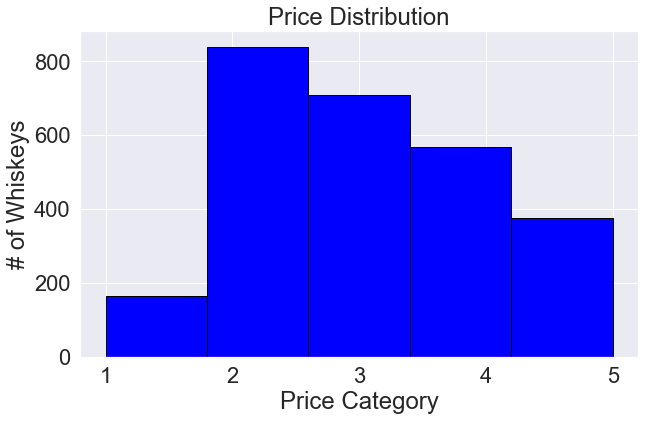

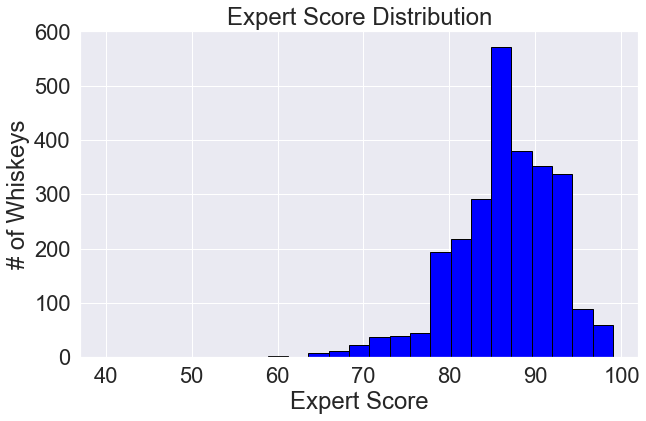

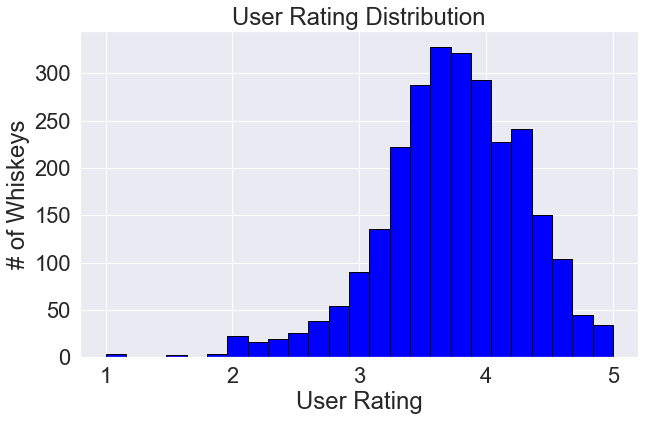

In [119]:
### plotting the distributions of price, expert score & user rating.

sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.hist(df['price'], bins = 5, edgecolor='black', color='blue')
plt.title('Price Distribution')
plt.xlabel('Price Category')
plt.ylabel('# of Whiskeys')

sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.hist(df['expert_score'], bins = 25, edgecolor='black', color='blue')
plt.title('Expert Score Distribution')
plt.xlabel('Expert Score')
plt.ylabel('# of Whiskeys')

sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.hist(df['user_rating'], bins = 25, edgecolor='black', color='blue')
plt.title('User Rating Distribution')
plt.xlabel('User Rating')
plt.ylabel('# of Whiskeys')

plt.show()

Price Category Summary
----------------------------------------
country    0    1   2   3   4
price                        
1         26   95  32  10   2
2        167  529  71  62  11
3        306  295  44  38  27
4        272  222  20  30  26
5        261   51   8  12  45

Price Category % to Total
----------------------------------------
country      0      1      2     3      4
price                                    
1       15.800 57.600 19.400 6.100  1.200
2       19.900 63.000  8.500 7.400  1.300
3       43.100 41.500  6.200 5.400  3.800
4       47.700 38.900  3.500 5.300  4.600
5       69.200 13.500  2.100 3.200 11.900

Country % to Total by Price
----------------------------------------
country      0      1      2      3      4
price                                     
1        2.500  8.000 18.300  6.600  1.800
2       16.200 44.400 40.600 40.800  9.900
3       29.700 24.700 25.100 25.000 24.300
4       26.400 18.600 11.400 19.700 23.400
5       25.300  4.300  4.600  7.900 

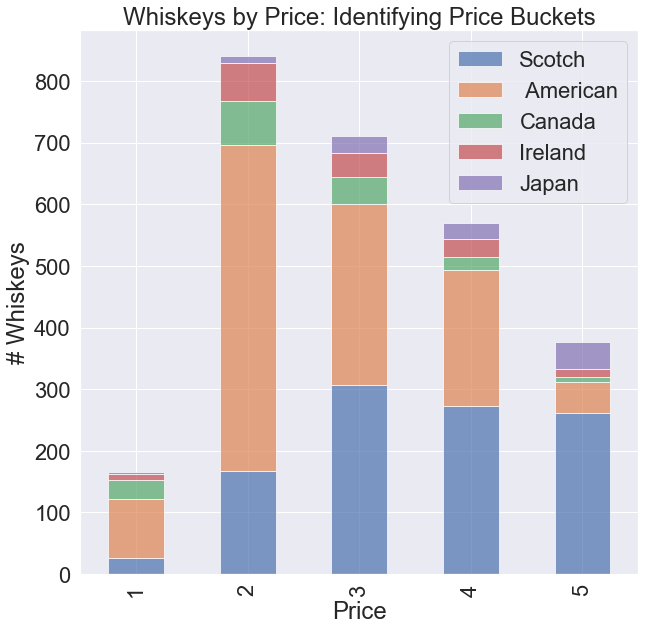

In [120]:
### capturing our price by country
### price in this data set is categorical -  listed as 1-5 where 1 is the least expensive and 5 is the most expensive

# count of the country observtions in each price bucket
print('Price Category Summary')
print("-"*40)
print(df.groupby(['price','country']).price.count().unstack())
print("")
# representation of the # of observations in each price bucket as a percentage
print('Price Category % to Total')
print("-"*40)
print(round((df.groupby(['price','country']).price.count()/df.groupby(['price']).price.count()*100), 1).unstack())
print("")
# repesentation of the price bucket makeup within each country as a percentage
print('Country % to Total by Price')
print("-"*40)
print(round((df.groupby(['price','country']).price.count()/df.groupby(['country']).country.count()*100), 1).unstack())
print("")

price = df.groupby(['price','country']).price.count().unstack()
p1 = price.plot(kind = 'bar', stacked = True, 
                   title = 'Whiskeys by Price: Identifying Price Buckets', 
                   alpha = .70, figsize=(10,10))
p1.set_xlabel('Price')
p1.set_ylabel('# Whiskeys')
p1.legend(['Scotch',' American', 'Canada', 'Ireland', 'Japan'])
plt.show()

From this graph, we can see that there is a difference between our countries of origin and the price. Scotch tends to 
be more expensive where American whiskey & Irish whiskey are on the lower end of the scale.

The next thing we want to understand is how are expert scores shake out among the countries or origin. 

Expert Score
----------------------------------------
count   2662.000
mean      86.391
std        5.895
min       40.000
25%       83.000
50%       87.000
75%       90.000
max       99.000
Name: expert_score, dtype: float64

Average Expert Score per Whiskey Origin
----------------------------------------
country
0   87.566
1   85.121
2   86.897
3   86.441
4   88.243
Name: expert_score, dtype: float64



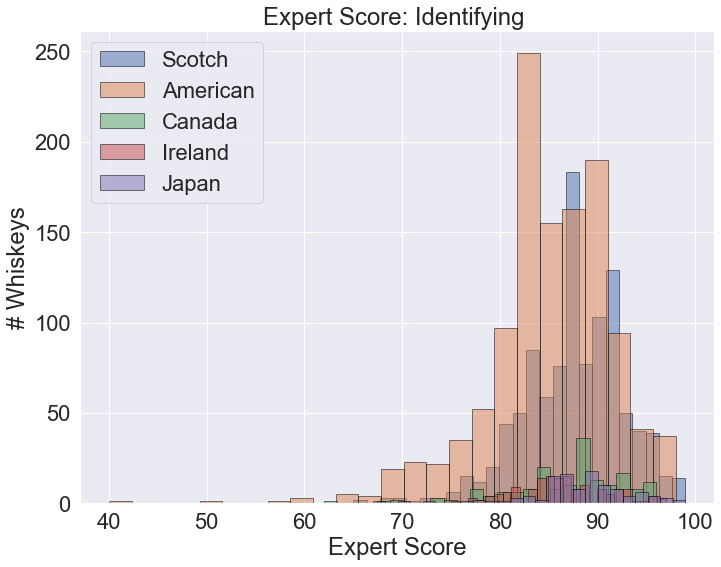

In [131]:
# first look at the spread of the total data in expert_score
print("Expert Score")
print("-"*40)
print(df.expert_score.describe())
print("")
# breaking down by country of origin how each performs within expert score
print("Average Expert Score per Whiskey Origin")
print("-"*40)
print(df.groupby(['country']).expert_score.mean())
print("")

sns.set_style('darkgrid')
fig = plt.figure(figsize = (25,20))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(df[df['country'] ==0].expert_score, bins = 25, label ='Scotch', alpha = .50,edgecolor= 'black')
ax1.hist(df[df['country']==1].expert_score, bins = 25, label = 'American', alpha = .50, edgecolor = 'black')
ax1.hist(df[df['country']==2].expert_score, bins = 25, label = 'Canada', alpha = .50, edgecolor = 'black')
ax1.hist(df[df['country']==3].expert_score, bins = 25, label = 'Ireland', alpha = .50, edgecolor = 'black')
ax1.hist(df[df['country']==4].expert_score, bins = 25, label = 'Japan', alpha = .50, edgecolor = 'black')
ax1.set_title('Expert Score: Identifying ')
ax1.set_xlabel('Expert Score')
ax1.set_ylabel('# Whiskeys')
ax1.legend(loc = 'upper left')

plt.show()

Average Expert Score by Price Category
----------------------------------------
country
0   87.566
1   85.121
2   86.897
3   86.441
4   88.243
Name: expert_score, dtype: float64

Average Expert Score by Price Category
----------------------------------------
country      0      1      2      3      4
price                                     
1       78.308 79.495 79.750 80.600 81.000
2       84.060 83.164 86.761 84.419 85.000
3       86.359 86.617 89.227 87.263 86.000
4       88.268 88.829 90.600 89.133 88.038
5       91.414 91.098 94.625 92.417 90.822



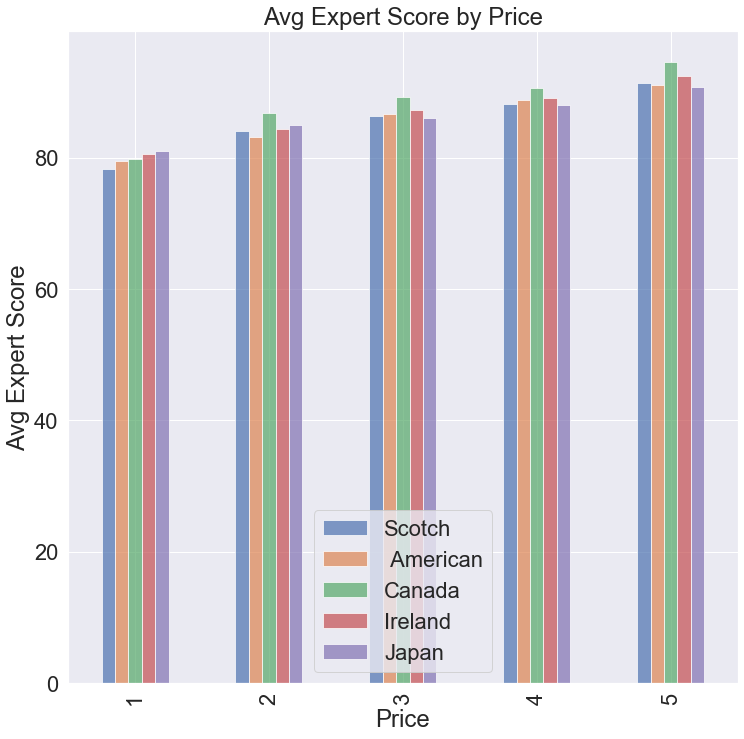

In [132]:
# comparing expert score & price
print("Average Expert Score by Price Category")
print("-"*40)
print(df.groupby(['country']).expert_score.mean())
print("")
print("Average Expert Score by Price Category")
print("-"*40)
print(df.groupby(['price', 'country']).expert_score.mean().unstack())
print("")
expert_price = df.groupby(['price', 'country']).expert_score.mean().unstack()
p1 = expert_price.plot(kind = 'bar', stacked = False, 
                   title = 'Avg Expert Score by Price', 
                   alpha = .70, figsize=(12,12))
p1.set_xlabel('Price')
p1.set_ylabel('Avg Expert Score')
p1.legend(['Scotch',' American', 'Canada', 'Ireland', 'Japan'], )
plt.show()

So across all our countries of origin, as the price increases, so does the expert score. And if you think about it, that makes sense. You expect a higher quality drink when you pay a premium. One interesting note is that Canadian whiskey in almost every price bucket is the highest rated on average.

Expert score is a good indication of that, but what about everyday consumer ratings? Consumesr and experts don't always agree on what makes something good. Do customers react to a given whiskey the same way the experts do?

Average Consumer Rating
----------------------------------------
count   2662.000
mean       3.738
std        0.559
min        1.000
25%        3.420
50%        3.750
75%        4.120
max        5.000
Name: user_rating, dtype: float64

Average Consumer Rating
----------------------------------------
country
0   3.855
1   3.643
2   3.587
3   3.701
4   3.950
Name: user_rating, dtype: float64

Consumer Rating Average by Price Category
----------------------------------------
country     0     1     2     3     4
price                                
1       2.763 3.156 2.998 3.127 2.775
2       3.380 3.423 3.502 3.436 3.451
3       3.738 3.793 3.828 3.759 3.696
4       3.959 4.045 4.049 4.014 3.953
5       4.298 4.213 4.213 4.576 4.274



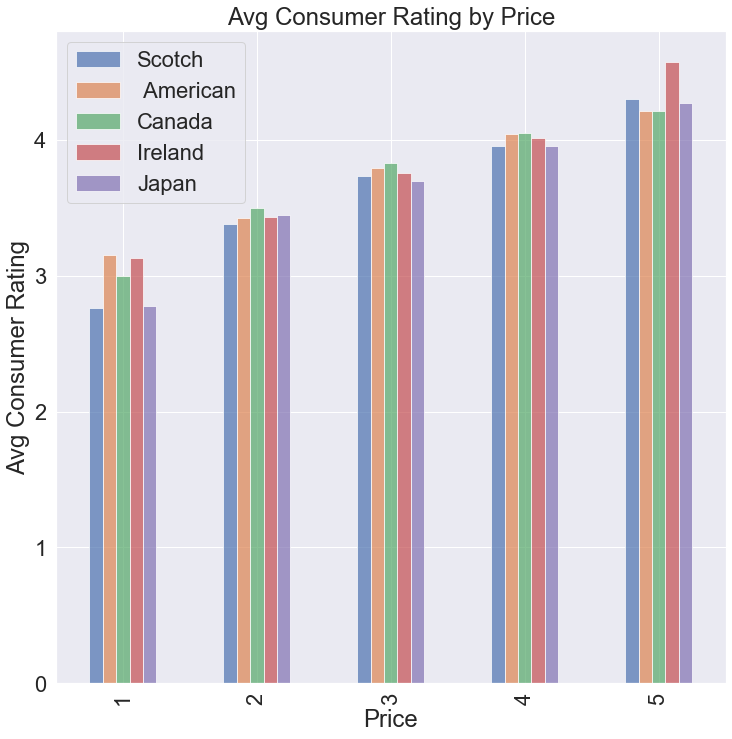

In [136]:
# looking at the consumer reaction to each whiskey using the user_rating column
print("Average Consumer Rating")
print("-"*40)
print(df.user_rating.describe())
print("")
print("Average Consumer Rating")
print("-"*40)
print(df.groupby(['country']).user_rating.mean())
print("")
# how does price affect consumer rating
print("Consumer Rating Average by Price Category")
print("-"*40)
print(df.groupby(['price', 'country']).user_rating.mean().unstack())

print("")

user_price = df.groupby(['price', 'country']).user_rating.mean().unstack()
p1 = user_price.plot(kind = 'bar', stacked = False, 
                   title = 'Avg Consumer Rating by Price', 
                   alpha = .70, figsize=(12,12))
p1.set_xlabel('Price')
p1.set_ylabel('Avg Consumer Rating')
p1.legend(['Scotch',' American', 'Canada', 'Ireland', 'Japan'], )
plt.show()

It looks like users also agree. The more expensive a whiskey, the higher the rating a user will give it. For the most expensive whiskey - price bucket 5 - Irish whiskey is rated noticeably higher than the other whiskeys. There could be something too that.

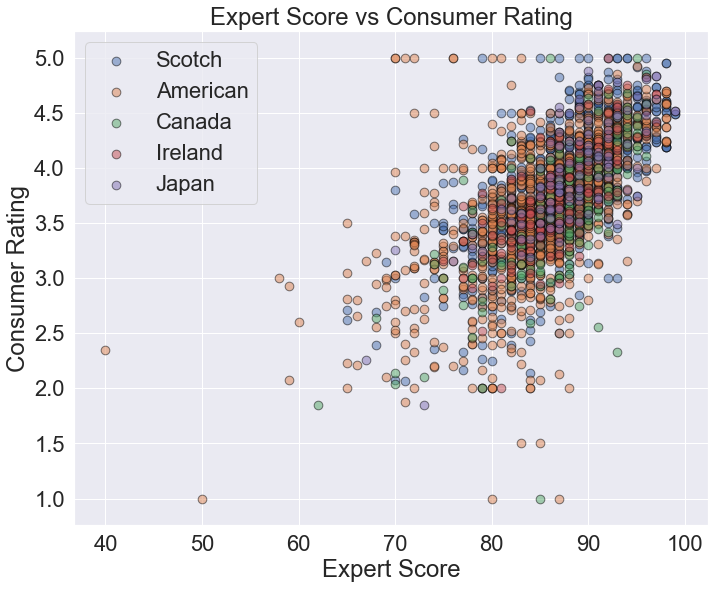

In [137]:
# comparing consumer rating & expert score
sns.set_style('darkgrid')
fig = plt.figure(figsize = (25,25))
fig.subplots_adjust(hspace = .75)

ax = fig.add_subplot(221)
ax.scatter(x = df[df['country']==0].expert_score, y = df[df['country']==0].user_rating,
                        alpha = .50,edgecolor= 'black', s= 75, label = 'Scotch')
ax.scatter(x = df[df['country']==1].expert_score, y = df[df['country']==1].user_rating,
                        alpha = .50,edgecolors= 'black', s= 75, label = 'American')
ax.scatter(x = df[df['country']==2].expert_score, y = df[df['country']==2].user_rating,
                        alpha = .50,edgecolors= 'black', s= 75, label = 'Canada')
ax.scatter(x = df[df['country']==3].expert_score, y = df[df['country']==3].user_rating,
                        alpha = .50,edgecolors= 'black', s= 75, label = 'Ireland')
ax.scatter(x = df[df['country']==4].expert_score, y = df[df['country']==4].user_rating,
                        alpha = .50,edgecolors= 'black', s= 75, label = 'Japan')
ax.set_xlabel('Expert Score')
ax.set_ylabel('Consumer Rating')
ax.set_title('Expert Score vs Consumer Rating')
ax.legend()

plt.show()

Cask Type Summary
----------------------------------------
country              0        1      2      3      4
cask_category                                       
bourbon        184.000   19.000 24.000 33.000  4.000
bourbon_oak     40.000   11.000 29.000  6.000  3.000
bourbon_sherry 176.000    2.000  3.000 29.000 11.000
new              1.000   15.000    nan  1.000    nan
oak            208.000 1032.000 64.000 65.000 35.000
other          198.000  101.000 47.000  7.000 38.000
sherry         122.000    1.000  1.000  8.000 11.000
sherry_oak      74.000    3.000  2.000    nan  6.000
used             6.000    5.000  2.000    nan    nan
wine            23.000    3.000  3.000  3.000  3.000

Cask Type % to Total
----------------------------------------
country             0      1      2      3     4
cask_category                                   
bourbon        69.700  7.200  9.100 12.500 1.500
bourbon_oak    44.900 12.400 32.600  6.700 3.400
bourbon_sherry 79.600  0.900  1.400 13.100 5.0

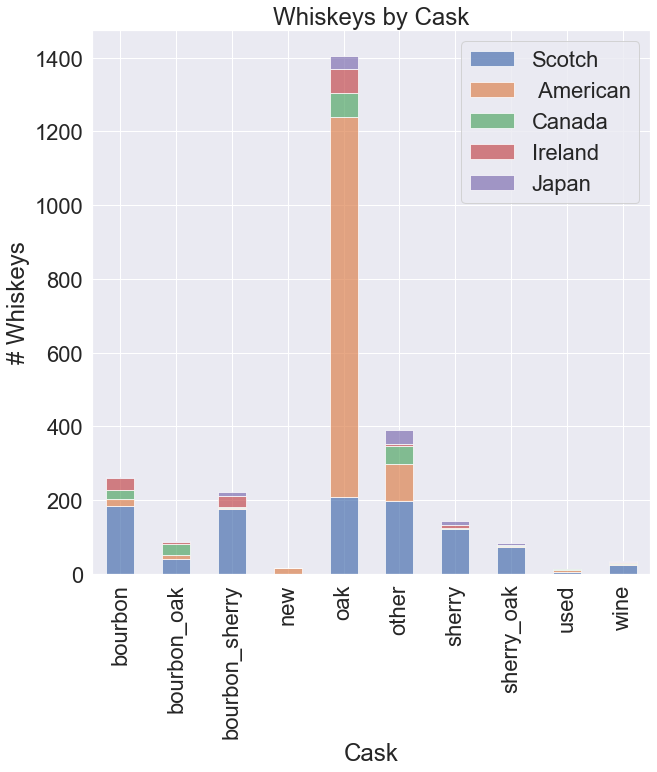

In [139]:
# seeing how our data is distributed by cask
print('Cask Type Summary')
print("-"*40)
print(df.groupby(['cask_category','country']).cask_category.count().unstack())
print("")
print('Cask Type % to Total')
print("-"*40)
print(round((df.groupby(['cask_category','country']).cask_category.count()/df.groupby(['cask_category']).cask_category.count()*100), 1).unstack())
print("")
print('Country % to Total by Cask')
print("-"*40)
print(round((df.groupby(['cask_category','country']).price.count()/df.groupby(['country']).country.count()*100), 1).unstack())
print("")

price = df.groupby(['cask_category','country']).cask_category.count().unstack()
p1 = price.plot(kind = 'bar', stacked = True, 
                   title = 'Whiskeys by Cask', 
                   alpha = .70, figsize=(10,10))
p1.set_xlabel('Cask')
p1.set_ylabel('# Whiskeys')
p1.legend(['Scotch',' American', 'Canada', 'Ireland', 'Japan'])
plt.show()

While a majority of American whiskey is made in oak casks, that's true for a lot of whiskeys. Oak makes up the biggest percentage for all 5 of our types. One thing we can do in the future is flesh out the cask category to make this more impactful in our model.

In [140]:
# looking at alcohol content in each of the types of whiskey
print("Average ABV Rating")
print("-"*40)
print(df.groupby(['country']).abv.mean())
print("")
print("Cask Type Avg ABV")
print("-"*40)
print(df.groupby(['cask_category', 'country']).abv.mean().unstack())

print("")

Average ABV Rating
----------------------------------------
country
0   46.530
1   48.162
2   43.731
3   44.064
4   45.489
Name: abv, dtype: float64

Cask Type Avg ABV
----------------------------------------
country             0      1      2      3      4
cask_category                                    
bourbon        46.986 43.332 43.246 45.273 47.675
bourbon_oak    46.913 45.977 42.545 48.000 56.000
bourbon_sherry 45.763 52.450 41.433 44.269 45.000
new            63.500 47.933    nan 45.000    nan
oak            46.304 48.694 45.655 42.126 43.211
other          45.664 44.093 42.274 45.229 46.750
sherry         47.814 52.500 46.000 48.825 45.445
sherry_oak     46.441 47.667 42.500    nan 44.833
used           48.017 44.500 42.500    nan    nan
wine           49.952 44.000 44.000 47.167 45.933



Average Consumer Rating & ABV
----------------------------------------
         user_rating    abv
country                    
0              3.855 46.530
1              3.643 48.162
2              3.587 43.731
3              3.701 44.064
4              3.950 45.489



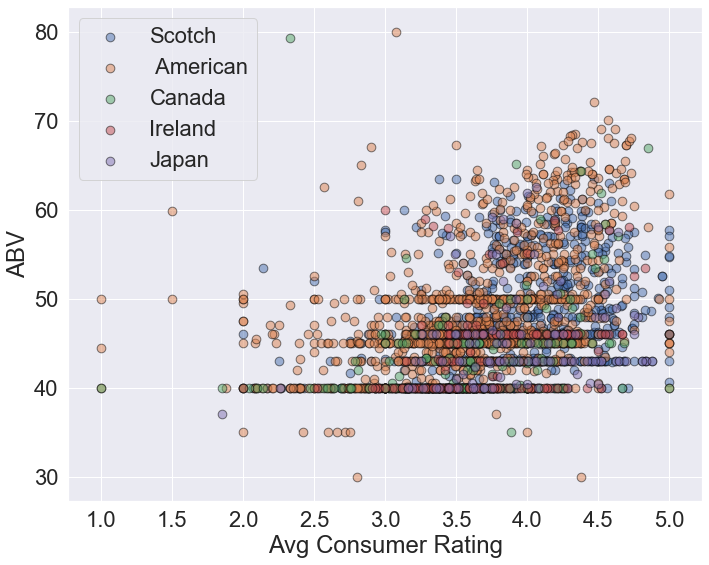

In [141]:
# comparing consumer rating & abv to see if there's a correlation between how much alcohol is in a particular whiskey
# and how much consumers react to it
print("Average Consumer Rating & ABV")
print("-"*40)
print(df.groupby(['country'])['user_rating', 'abv'].mean())
print("")

sns.set_style('darkgrid')
fig = plt.figure(figsize = (25,25))
fig.subplots_adjust(hspace = .75)

ax = fig.add_subplot(221)

ax.scatter(x = df[df['country']==0].user_rating, y = df[df['country']==0].abv,
                        alpha = .50,edgecolor= 'black', s= 75, label = 'Scotch')
ax.scatter(x = df[df['country']==1].user_rating, y = df[df['country']==1].abv,
                        alpha = .50,edgecolors= 'black', s= 75, label = 'American')
ax.scatter(x = df[df['country']==2].user_rating, y = df[df['country']==2].abv,
                        alpha = .50,edgecolors= 'black', s= 75, label = 'Canada')
ax.scatter(x = df[df['country']==3].user_rating, y = df[df['country']==3].abv,
                        alpha = .50,edgecolors= 'black', s= 75, label = 'Ireland')
ax.scatter(x = df[df['country']==4].user_rating, y = df[df['country']==4].abv,
                        alpha = .50,edgecolors= 'black', s= 75, label = 'Japan')
plt.xlabel('Avg Consumer Rating')
plt.ylabel('ABV')
plt.legend(['Scotch',' American', 'Canada', 'Ireland', 'Japan'], )
plt.show()

# New Features

In [142]:
# looking at the distributions of our price feature, it's more likely that a given whiskey will be Scotch or Japanese.
# this new column should help capture the country of origin along with our other features.

df['big_ticket'] = df['price'] >= 4
df['big_ticket'].value_counts()

False    1715
True      947
Name: big_ticket, dtype: int64

In [143]:
# american whiskey tends to have lower expert scores which makes sense because they also tend to be in the lower
# price buckets. a new 'poor_performer' column will capture those whiskeys that fall short.
# to do this, we want to capture those observations that fall 15% below the average expert score

df['poor_performer'] = df['expert_score'] < df['expert_score'].mean() * .85
df['poor_performer'].value_counts()

False    2576
True       86
Name: poor_performer, dtype: int64

In [144]:
# irish whiskey has a really strong user rating in the most expensive price bucket
# we want to use that to help identify our target varaible in a new column 'people_love_this'

df['people_love_this'] = (df['price'] == 5) &(df['user_rating'] > 4.3)
df['people_love_this'].value_counts()

False    2458
True      204
Name: people_love_this, dtype: int64

In [145]:
df.head()

,name,type,price,expert_score,user_rating,description,abv,style,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country,cask_category,bourbon_oak,bourbon_sherry,new,oak,other,sherry,sherry_oak,used,wine,poor_performer,people_love_this,big_ticket
0,Hibiki 21 Year,Blended,5,99,4.520,Hibiki is the blended whisky brand produced by...,43.000,Comprised of both single malt(s) and single gr...,"""Tasting this whisky was one of those moments ...",30,30,50,30,20,80,80,85,0,15,20,25,85,50,4,oak,0,0,0,1,0,0,0,0,0,False,True,True
1,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0,sherry,0,0,0,0,0,1,0,0,0,False,False,True
2,George T. Stagg Bourbon (Fall 2019),Bourbon,4,98,4.590,George T. Stagg Bourbon (Fall 2019) is an uncu...,58.450,Produced anywhere in USA; Mash bill of at leas...,"""Lots of oak shows up on the nose along with c...",40,40,65,50,20,60,60,45,0,0,60,60,45,0,1,oak,0,0,0,1,0,0,0,0,0,False,False,True
3,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,"""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0,bourbon_sherry,0,1,0,0,0,0,0,0,0,False,False,True
4,The Macallan M,Single Malt,5,98,4.190,A 6-litre Lalique decanter of this single malt...,47.700,Distilled in pot stills from 100% malted barle...,"""The aroma is that pleasing bouquet that comes...",50,50,60,0,15,90,100,50,0,0,20,20,80,10,0,sherry_oak,0,0,0,0,0,0,1,0,0,False,False,True


In [147]:
df.to_csv("whiskey_feat_engineered.csv")